# Predict C-to-U editing sites from nucleotide windows



## Environment

In [1]:
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

## Deepred-Mt installation

In [2]:
!pip install -U "deepredmt @ git+https://github.com/aedera/deepredmt.git" > /dev/null

  Running command git clone -q https://github.com/aedera/deepredmt.git /tmp/pip-install-lzgghqjc/deepredmt


## Make predictions

To make predictions, we will use the nucleotide windows available in the data used to train Deepred-Mt.

In [3]:
!wget https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz

--2021-05-09 20:21:04--  https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2715985 (2.6M) [application/octet-stream]
Saving to: ‘training-data.tsv.gz’

training-data.tsv.g 100%[===================>]   2.59M  --.-KB/s    in 0.09s   

2021-05-09 20:21:04 (30.4 MB/s) - ‘training-data.tsv.gz’ saved [2715985/2715985]



As it is explained in the [README](https://github.com/aedera/deepredmt#datasets), these data is composed of ten fields.

In [4]:
!zcat training-data.tsv.gz | shuf | head -10 | column -t

Nelumbo_nucifera!rps13!265       rps13!265   1  TAACTAAGTATCAGATCGAC  C  AAATTGAACAAATGATAGGT  CAA  0.0134  0  0.00
Helianthus_annuus!mttB!127       mttB!172    1  CTCATATATECTATGAATTT  E  ATTTCGCAEEGGAAACTATT  EAT  0.7500  1  0.12
Rhazya_stricta!ccmFn!974         ccmFn!1094  2  GGGCTTTGGCTTATGTAGAT  C  AAAAATGATGAATGAGATTG  TCA  0.0055  0  0.00
Daucus_carota!ccmC!676           ccmC!709    1  CATCAATACATGTTECTATG  C  ECATTCCAATCTTGTCTAAC  CEC  0.0016  0  0.00
Nelumbo_nucifera!rpl10!547       rpl10!580   1  ATCTTTGTTTCGTGTGTTCC  C  GGGAGGAATTCGATCTCTTA  CGG  0.0056  0  0.00
Beta_vulgaris!ccmFc!886          ccmFc!1063  1  TGTCTAACACAAAGAAGATA  C  AGTTCACTCAACGATTGCCT  CAG  0.0000  0  0.00
Allium_cepa!nad6!878             nad6!977    2  CGCTGCCTACAGACGCTTCG  C  TTCCCCCCTACCTTTGAAAA  GCT  0.0000  0  0.00
Beta_vulgaris!ccmFc!1231         ccmFc!1471  1  GCACGACTGAAGTGGCTATC  C  ATACAAATCEATTTACGGAT  CAT  0.0167  0  0.00
Oryza_sativa!rps02!1522          rps02!2071  1  ATCCCCTTAGTTTTCAGGAT  C 

From these data, we will only use the nucleotide windows with either cytidines (C) or editing sites (E) in their center positions (field #5).

In [5]:
!zcat training-data.tsv.gz | \
  awk -F$'\t' '($$5 == "C" || $$5 == "E")' > reduced-data.tsv
  
!shuf reduced-data.tsv | head -10 | column -t

Ginkgo_biloba!rps03!316           rps03!316  1  TTCCTAAAAGGACATTEATT  C  ATTTATETCTTCCCCGTCGA  CAT  0.0066  0  0.00
Physcomitrella_patens!ccmB!488    ccmB!602   2  AAATCTTACCACTTTACCCA  C  TCTATTACCCTTAATCATTT  ACT  0.0000  0  0.00
Liriodendron_tulipifera!nad3!162  nad3!273   3  AGTCEGCTAGTTTCTTTGAT  C  EEACTCGGTGTTCCTTTTCE  ATC  0.0047  0  0.00
Gossypium_hirsutum!atp8!545       atp8!602   2  CATAATGCTAATCCATGTTC  E  ACACGGCCAAGGAAGCATTT  CEA  0.9738  1  0.75
Gossypium_hirsutum!mttB!671       mttB!716   2  TGTGATCEGTTTGCEAGAAC  E  AAGGGGTCTTTCTGTGGAAA  CEA  0.9461  1  0.50
Liriodendron_tulipifera!matR!722  matR!818   2  GAAAAAGCCTTTCGTTTTCC  C  CCCTTCGTCGGCCCTTGCCA  CCC  0.0147  0  0.00
Daucus_carota!nad5-1!149          nad5!149   2  CCTGCTCGGTAGTTCCGTAG  C  AGGTTTTTTCGGACGTTTTC  GCA  0.0000  0  0.00
Arabidopsis_thaliana!atp1!741     atp1!753   3  GTAGCGATTGGACAGAAACG  C  TCGACTGTGGGACAATTAAT  CGC  0.0007  0  0.00
Silene_conica!nad2!568            nad2!571   1  ATGTGATCGCAGCATCAAAA  C 

From the reduced data, we will extract the nucleotide windows (fields #4, #5, and #6). 

In [6]:
!cat reduced-data.tsv | \
  cut -f4,5,6 | \
  tr -d '\t' > wins.tsv

!shuf wins.tsv | head -10 | column -t

GTACACATTCCGACGATTGGCCGAGCGGATAAGTCAACTTC
CTTGGGCTCAAATAAGGGGTCTGTCAGTAACCTAGACCTAG
GCAGCCGAACCTTTACAACTCTCATTTCAAGACGCCGCTAC
ATEAAAAGGAAGAGAAGAATEAAAAGGATEGAACTACCTAC
TAGTACTCCTTGAGCTAATCECTEATTGTTTTCGTGCATTA
AGGTGTATATTCTCATTCTGCCTGGATTCGGTATCATAAGT
CTCAACACTGAAATATGCCECAAACTGAAAAAACGACGGCC
GTTTTTTGATACACCTAGGACATGGATTTTATATGAACCAA
AGGAGGACACTGGGCGGGATCTATCAGCAGCGAATTECCEA
CCTTAGCCCTGTCCTATCATCTGTATAATGGAGTTCGTCAT


Now, we can execute Deepred-Mt using the file `training-dataset.tsv` as input.

In [7]:
!deepredmt wins.tsv > deepredmt-pred.tsv

2021-05-09 20:21:06.068061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-09 20:21:10.056833: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 20:21:10.093697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-09 20:21:10.168432: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-09 20:21:10.168500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5de69d93a708): /proc/driver/nvidia/version does not exist
2021-05-09 20:21:10.169321: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 20:21:17.401583: I tensorflow/compiler/mlir/mlir_graph_optimizati

The output file `deepredmt-pred.tsv` contains the Deepred-Mt predictions.

In [8]:
!head -10 deepredmt-pred.tsv | column -t

0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00


To facilitate downstream analyses, we can add these predictions as a new last column in the original data.

In [9]:
!paste reduced-data.tsv deepredmt-pred.tsv > all-wins.tsv
!head -10 all-wins.tsv | column -t

Allium_cepa!atp1!1002  atp1!1020  3  GCTTTCCCTGGGGATGTTTT  C  TATTTACATTCCCGTCTCTT  TTC  0.0011  0  0.00  0.00
Allium_cepa!atp1!1009  atp1!1027  1  CTGGGGATGTTTTCTATTTA  C  ATTCCCGTCTCTTAGAAAGA  CAT  0.0002  0  0.00  0.00
Allium_cepa!atp1!1013  atp1!1031  2  GGATGTTTTCTATTTACATT  C  CCGTCTCTTAGAAAGAGCCG  TCC  0.0002  0  0.00  0.00
Allium_cepa!atp1!1014  atp1!1032  3  GATGTTTTCTATTTACATTC  C  CGTCTCTTAGAAAGAGCCGC  TCC  0.0010  0  0.00  0.00
Allium_cepa!atp1!1015  atp1!1033  1  ATGTTTTCTATTTACATTCC  C  GTCTCTTAGAAAGAGCCGCT  CGT  0.0000  0  0.00  0.00
Allium_cepa!atp1!1018  atp1!1036  1  TTTTCTATTTACATTCCCGT  C  TCTTAGAAAGAGCCGCTAAA  CTC  0.0002  0  0.00  0.00
Allium_cepa!atp1!1020  atp1!1038  3  TTCTATTTACATTCCCGTCT  C  TTAGAAAGAGCCGCTAAACG  CTC  0.0018  0  0.00  0.00
Allium_cepa!atp1!1031  atp1!1049  2  TTCCCGTCTCTTAGAAAGAG  C  CGCTAAACGATCGGACCAGA  GCC  0.0000  0  0.00  0.00
Allium_cepa!atp1!1032  atp1!1050  3  TCCCGTCTCTTAGAAAGAGC  C  GCTAAACGATCGGACCAGAC  GCC  0.0000  0  0.00  0.00
A

## Comparing the predictive performance of PREP-Mt and Deepred-Mt

Based on these predictions, we can compare the predicive performance of Deepred-Mt with that of [PREP-Mt](http://prep.unl.edu/), a state-of-the-art method to predict editing sites. To facilitate this comparison, we have already obtained the PREP-Mt predictions, which are available in the field #10 in the data used above.



To measure the predictive performance, precision and recall are standard metrics often used when the classes are imbalanced. You can find more information regarding these metrics in other [notebook](https://colab.research.google.com/github/aedera/deepredmt/blob/main/notebooks/01_prediction_from_fasta.ipynb).

In [10]:
# This command reads the columns 9, 10, 11 in the all-wins.tsv
preds = np.loadtxt('all-wins.tsv', usecols=(8, 9, 10))
y_true, y_prepmt, y_deepredmt = preds[:,0], preds[:,1], preds[:,2]

print(y_true[0:10], y_prepmt[0:10], y_deepredmt[0:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# calculate metrics for different thresholds
prepmt_pre, prepmt_rec, _ = metrics.precision_recall_curve(y_true, y_prepmt)
deepredmt_pre, deepredmt_rec, _ = metrics.precision_recall_curve(y_true, y_deepredmt)

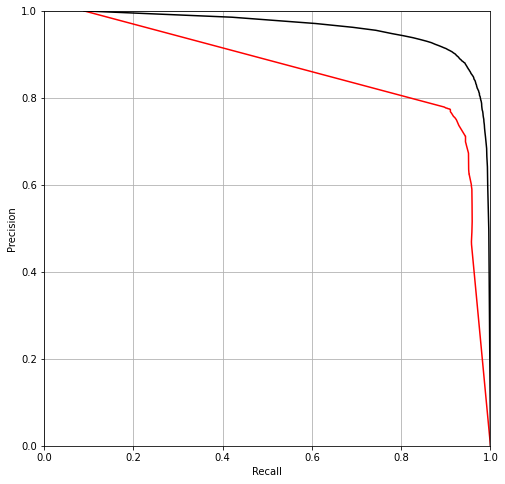

In [12]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 8))

# draw curves
plt.plot(prepmt_pre, prepmt_rec, c='red')
plt.plot(deepredmt_pre, deepredmt_rec, c='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.grid(True)

plt.show()